### Lab 3: Asking a Statistical Question
#### Jennifer Vo, lab partners with William Olsen
In this lab we will focus on asking statistical questions. The entire process typically involves 3 steps:
1. Writing down in words very precisely what question you are trying to ask.
2. Translating the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and then doing the integral to obtain a probability.
3. Coverting the probability into an equivalent sigma value.

In this lab, I will assume that I know the form of the signal-free background distribution. In each of the three problems in this lab, my task is to state the statistical question, convert it to math, then perform the associated analyses.

### Problem 1
For this first problem, I am looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin. Assume that the data is mostly consistent with 12 Kelvin, to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). 

My goal is to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). We also want to throw out values when we had an error in the thermometry such that the true temperature was fine, and we just had a wonky reading - just to be cautious.

First, I will import libraries and simulate some data. I will simulate 100k "good" data points assuming Gaussian fluctuations, and will also add the following "bad" datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

In [1]:
# First let's import the libraries I will be using
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (8,6)

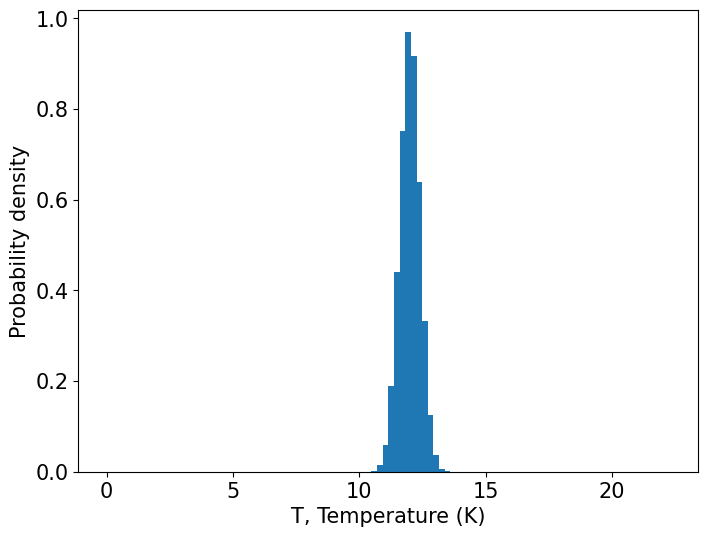

In [25]:
mean_data = 12
std_data = 0.4
N_good = 100000
bad_data = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
N_bad = len(bad_data)
data = np.append(stats.norm.rvs(loc = mean_data, scale = std_data, size = N_good), bad_data)
plt.hist(data,100, density=True)
plt.tick_params(labelsize = 15)
plt.ylabel('Probability density', fontsize = 15)
plt.xlabel('T, Temperature (K)', fontsize = 15)
plt.show()

#### Part A.

First, our goal is to identify bad data and throw it out. I will do this by first exploring the data I created with appropriate plots. Let's plot our original distribution onto a semi-log plot. I will also plot a Gaussian distribution on this to see how the distribution compares.

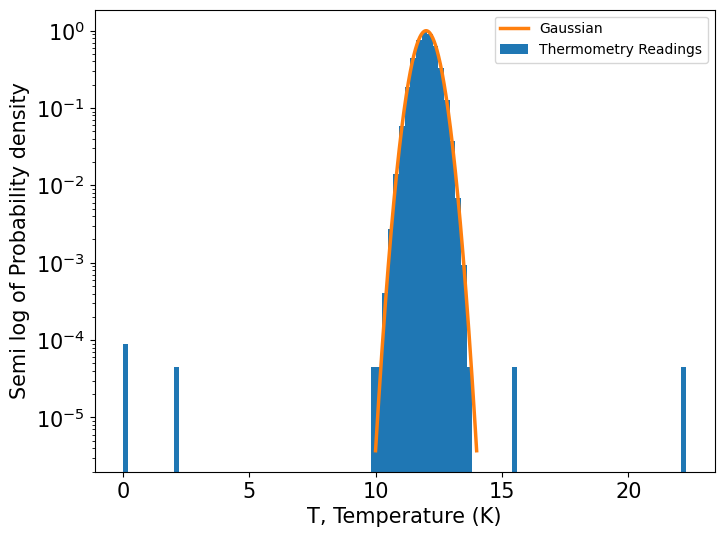

In [26]:
plt.hist(data,100, density=True, label = 'Thermometry Readings')

# Create a linear space for the Gaussian that is +/- 2 away from the mean
x = np.linspace(10,14,1000)
plt.plot(x, stats.norm.pdf(x, loc = mean_data, scale = std_data), linewidth = 2.5, label = 'Gaussian')

plt.yscale('log')
plt.legend()
plt.tick_params(labelsize = 15)
plt.ylabel('Semi log of Probability density', fontsize = 15)
plt.xlabel('T, Temperature (K)', fontsize = 15)
plt.show()

From the semi-log plot, we can observe that the data near the T = 12 K around the distribution mean looks characteristic of the Gaussian distribution, forming an upside-down parabolic shape. The data points at 0, 2.1, 10, 15.6, and 22.3 all appear to be outliers. How do I actually know whether they are anomalies?

The physics community considers data points with a significance of 5 $\sigma$ or greater "discoveries", in other words, statistically significant. I will use this threshold to determine which data points I will consider "bad" and therefore throw out. I will ask the following statistical question: 

(Be very clear, and describe why you have chosen this statistical question.)
**"What temperature measurement, greater than the distribution mean of 12 K, would my thermometry reading have to produce in order to give me a statistical significance of 5 $\sigma$ or greater?"**

The answer to this question will be some degrees Kelvin away from the mean. The question is framed to find temperature measurements above the mean, but I will take the answer and apply it to both temperature differences above the mean and below the mean when considering data points to drop, as the distribution should be symmetric. If a temperature measurement gives me a statistical significance of greater than 5 $\sigma$, I will assume that the the thermal control system was misbehaving and I will drop that data point.

I need to restate my statistical question in math. I will need to convert my threshold of 5 sigma to a corresponding probability using the survival function (sf) of scipy.stats.norm with a normal distribution of mean 0 and standard deviation 1. Then, I can take the calculated probability and use the inverse survival function on a Gaussian with mean 12 K and standard deviation of 0.4 K, to determine what temperature will give me a significance of 5 $\sigma$.

I can convert this question into a mathematical expression, where the answer to the question asked is given by T'. The normal distribution has mean of 0 and standard deviation of 1, so 5 $\sigma$ away from the mean is x = 5. The probability we want thus ranges from 5 to $\infty$. :

$$ \int_{5}^{\infty} \frac{1}{\sqrt{2\pi}}e^{-x^2/2} dx = \int_{T'}^{\infty} \frac{1}{0.4\sqrt{2\pi}}e^{-\frac{1}{2}((T-12)/0.4)^2} dT $$

The probability distribution we will use to model the data is a Gaussian distribution with mean of 12 K and standard deviation of 0.4 K. (I will note that the actual Gaussian distribution technically ranges from -$\infty$ to $\infty$, but with probabilities of measuring negative temperatures here being over (12-0)/0.4 = 30 standard deviations away from the mean, we can ignore this minor detail.)

Let's convert this math into code and solve for T', the temperature measurement over the mean of 12 K that would give us a statistical significance of 5 $\sigma$. I will use, as stated before, the survival function and the inverse survival function.

In [4]:
sigma_a = 5
prob_a = stats.norm.sf(sigma_a)

T_prime = stats.norm.isf(prob_a, loc = mean_data, scale = std_data)
print(f'The temperature measurement greater than the mean of 12 K the thermometry reading would have to produce in order to obtain a statistical significance of 5 sigma or greater is {T_prime:.2f} K')

The temperature measurement greater than the mean of 12 K the thermometry reading would have to produce in order to obtain a statistical significance of 5 sigma or greater is 14.00 K


14 K is exactly 2 K greater than the mean. Since the actual distribution should be symmetric, we would exclude data points that are less than or equal to 10 K (=12K-2K), and greater than or equal to 14 K. 

I can construct a truth table representing the results of the data points that were classified as Good vs Bad data points with my test, and compare that to what were True Temperatures and Bad Temperatures. I know that I created the data with 100k true Gaussian data points and 8 "bad" data points. I can calculate the number of data points that were classified as good and bad according to my test of 5 sigma significance, then I will construct this truth table.

In [5]:
test_count_bad = 0
test_count_good = 0

for i in range (0, len(data)):
    if data[i] <= 10 or data[i] >= 14:
        test_count_bad += 1
    else:
        test_count_good += 1
        
print(f'I have a total of {N_good} true T data points and {N_bad} bad T data points.')
print(f'The total count of bad data points according to my 5 sigma test is {test_count_bad}.')
print(f'The total count of good data points according to my 5 sigma test is {test_count_good}.')

I have a total of 100000 true T data points and 8 bad T data points.
The total count of bad data points according to my 5 sigma test is 6.
The total count of good data points according to my 5 sigma test is 100002.


Thus the following truth table can be constructed:

|  | True T | Bad T|
|----|----|----------|
| My Test Good | 100,000  | 2  |
| My Test Bad | 0  | 6 |

#### Part B.

The test I constructed in Part A was based off of a statistical threshold of 5 sigma. Now I would like to ask, how does the number of data points my test omits depend on this statistical threshold? If I have a higher statistical threshold, I expect my test to omit fewer data points, and with a lower statistical threshold, I expect my test to omit more data points. Let's test this theory with $\sigma$ = 4, 6, and 10.

In [6]:
def calc_num_omitted(sigma):
    prob = stats.norm.sf(sigma)

    T_prime = stats.norm.isf(prob, loc = mean_data, scale = std_data)
    test_count_bad = 0
    test_count_good = 0
    for i in range (0, len(data)):
        if data[i] <= 24-T_prime or data[i] >= (T_prime):
            test_count_bad += 1

    print(f'The total count of bad data points according to my {sigma} sigma test is {test_count_bad}.')

calc_num_omitted(4)
calc_num_omitted(6)
calc_num_omitted(10)

The total count of bad data points according to my 4 sigma test is 11.
The total count of bad data points according to my 6 sigma test is 5.
The total count of bad data points according to my 10 sigma test is 4.


As I can observe, my prediction was correct that a higher statistical threshold will omit fewer data points. This makes sense, considering a higher threshold means a greater sigma required for "significance" and thus there will be fewer data points acheiving that significance. The number of temperature measurements omitted is a predictable quantity. Sigma is a measure of standard deviation away from the mean of the normal Gaussian distribution (mean of 0 and standard deviation of 1). By definition, a value of 5 $\sigma$ means points which are 5 standard deviations away from the mean. We can easily convert some common standard deviation ranges to a percentage of the total data that is included within that range:
- +/- 1 $\sigma$ away from the mean includes 68.26% of the data
- +/- 2 $\sigma$ away from the mean includes 95.44% of the data
- +/- 3 $\sigma$ away from the mean includes 99.7% of the data

And so on and so forth. These probabilities eventually converge to 1 as we increase $\sigma$ to greater and greater values, as they should for a normalized distribution. However, what this means is that we can extend these probabilities of sigmas to our own distribution. A significance of 3$\sigma$ in our distribution would omit approximately 1-0.997 = 0.003 or 0.3% of our data. Since our dataset has 100,008 points, this means about 300 temperature measurements would be omitted in our test, for a threshold of 3$\sigma$. Thus, we can take any statistical threshold and calculate a prediction for a corresponding number of points omitted by my test.

#### Part C.

Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

As we can observe from my truth table construction, there are still 2 bad temperature measurements that were categorized as "good" data in my test. Bad data getting in is also called mistakes of commission. These are avoidable if our test can omit them, which depends on our statistical threshold. Lowering the statistical threshold by choosing smaller values of $\sigma$ would result in fewer mistakes of commission, but this would also lead to omission of true temperature data points. Depending on where the bad data points are exactly, our test may not be able to avoid them getting in without sacrificing a significant amount of data. The decision of where the statistical threshold should lie will greatly depend on the experiment in question and where the bad data points are. The closer they are to the mean, the more difficult it is to avoid those mistakes of commission. 

### Problem 2

In this problem I will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS (another name for standard deviation). If I histogram how far all the (stationary) stars appear to have moved I get something like the result of the following code:

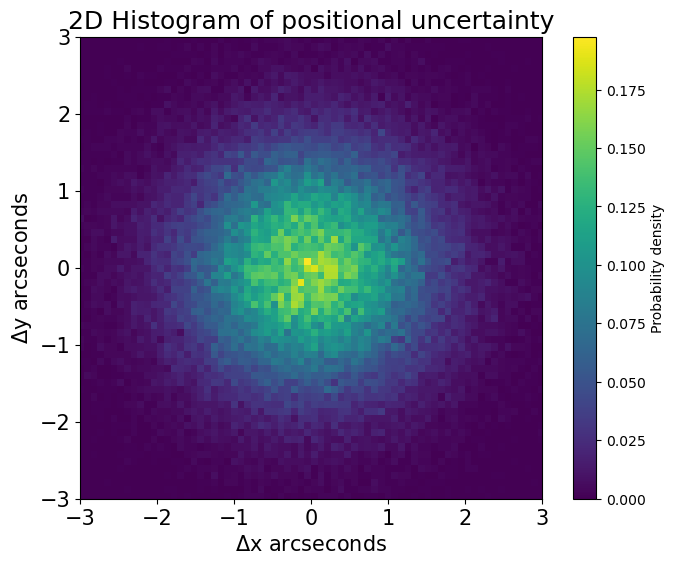

In [27]:
# Note: Both 1 dimensional distributions are Gaussian normal distributions with mean = 0 and standard deviation = 1.
a = np.vstack((stats.norm.rvs(scale = 1, size = 100000), stats.norm.rvs(scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.tick_params(labelsize = 15)
plt.title("2D Histogram of positional uncertainty", fontsize = 18)
plt.ylabel("$\Delta$y arcseconds", fontsize = 15)
plt.xlabel("$\Delta$x arcseconds", fontsize = 15)
plt.colorbar(h[3], ax=ax, label = 'Probability density')
plt.show()

Where x and y are orthogonal spatial directions.

#### Part A.
If I have a potential asteroid, it will have some true movement between the images. Let's explore what a '5 sigma' detection of movement would look like. I want to determine: what is that distance in arcseconds? 

The statistical question I would like to answer is: 
**"What distance in arcseconds would I need to measure in order for my background to produce a signal with a statistical significance of 5$\sigma$?"**

#### Part B.

The analytic description of the background distribution is best modeled by the Rayleigh probability distribution, which maps the probability of different amplitudes of a 2-dimensional vector with Gaussian-distributed components with given standard deviation and a mean of 0. 

The probability I would need for a 5$\sigma$ significance can be calculated as in Problem 1, through converting 5 sigma to a corresponding probability with the survival function (sf) using with a normal distribution of mean 0 and standard deviation 1. Then, I will take the calculated probability and use the inverse survival function on a Rayleigh distribution with scale parameter of 1 arcsecond RMS, to determine what distance in arcseconds would give me a significance of 5 $\sigma$.

Let us define $z = \sqrt{x^2+y^2}$, then the pdf is defined for z $\geq$ 0 as:
$$\text{pdf(z) = }\frac{z}{\sigma^2}e^{-z^2/(2\sigma^2)}$$

The normal distribution has mean of 0 and standard deviation of 1, so 5 $\sigma$ away from the mean is x = 5. The probability we want thus ranges from 5 to $\infty$. Our statistical question can thus be expressed with the following mathematical equation, where the answer to the question asked is given by z':

$$ \int_{5}^{\infty} \frac{1}{\sqrt{2\pi}}e^{-x^2/2} dx = \int_{z'}^{\infty} \frac{z}{\sigma^2}e^{-z^2/(2\sigma^2)}dz = \int_{z'}^{\infty} z e^{-z^2/2}dz$$

I will also plot the background distribution of the images with a Rayleigh distribution with scale parameter 1 arcsecond RMS in order to visualize the distribution and determine if the answer to my question makes sense.

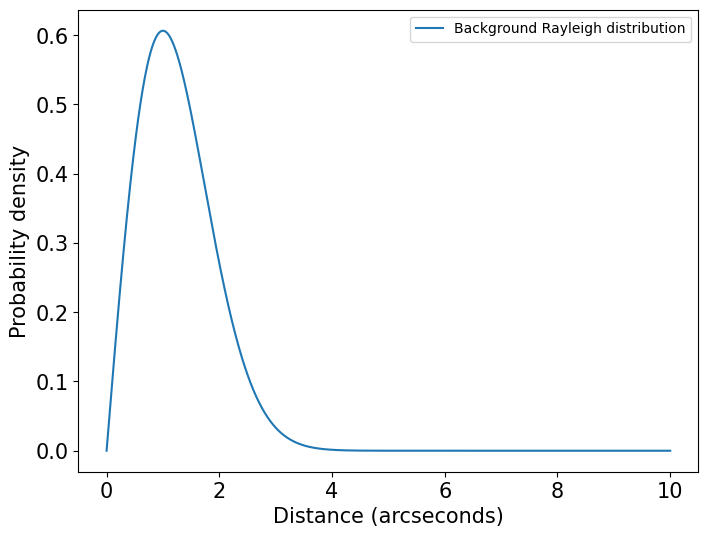

In [28]:
std_rayleigh = 1
d_rayleigh = np.linspace(0,10,1000) #distance
p_rayleigh = stats.rayleigh.pdf(d_rayleigh, scale = std_rayleigh) #probability
plt.plot(d_rayleigh, p_rayleigh, label = 'Background Rayleigh distribution')
plt.tick_params(labelsize = 15)
plt.xlabel("Distance (arcseconds)", fontsize = 15)
plt.ylabel("Probability density", fontsize = 15)
plt.legend()
plt.show()

#### Part C.

Now, I will compute this distance in arcseconds to determine what signal would represent a 5 sigma detection of motion.

In [23]:
sigma_b = 5
std_rayleigh = 1
prob_b = stats.norm.sf(sigma_b)

z_prime = stats.rayleigh.isf(prob_b, scale = std_rayleigh)
print(f'The distance measurement I would need to detect in order to obtain a statistical significance of 5 sigma or greater is {z_prime:.2f} arcseconds.')

The distance measurement I would need to detect in order to obtain a statistical significance of 5 sigma or greater is 5.49 arcseconds.


As we can see observe from the plot, a distance measurement of 5.49 arcseconds looks to be on the far right end of the tail of the distribution, where the probability density is very low. This means sense, as a statistical significance of 5 sigma is required for "discovery" in physics, and a measurement that has a very low probability of occurring would be what we expect to find.

### Problem 3